In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
from scipy.stats import pearsonr
import pandas as pd

import sys
sys.path.append('data')
import backboning

# Part 1: Network Analysis

In [2]:
G = nx.read_graphml("data/world_graph_attributes.graphml")

In [10]:
isolated_nodes = list(nx.isolates(G))
print("Isolated nodes:", isolated_nodes)

Isolated nodes: []


In [3]:
G.number_of_nodes()

192

In [4]:
G.number_of_edges()

2115

## 1. Qualitative Analysis

The **in-degree** of a node represents how many countries mention that particular country, showing which countries influence world history the most. These are the United States, United Kingdom and France.

The **out-degree** represents how many countries are part of the node's country history. It reveals countries which were influenced my many other countries. These are Iran, Russia and Argentina. Countries with long, well-documented international histories

The **total degree** corresponds to the sum of in and out-degree and it should represent the balance betweene the influence of a country and how influenced by others it is. However, by the results shown above, the in-degree values are way higher than the out-degree ones, so the total distribution will most likely be dominated by the in-degree. Countries with top total degree are the United States, the United Kingdom and France, the same as for the in-degree, as predicted.

In [36]:
no_nodes = G.number_of_nodes()
no_edges=G.number_of_edges()
print("Number of nodes:", no_nodes)
print("Number of edges:", no_edges)

#Highest in
in_degrees = dict(G.in_degree())
sorted_nodes_in = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)
highest_in=sorted_nodes_in[:20]
print("\nHighest in-degree nodes and their in-degree value:", highest_in)

#Highest out 
out_degrees = dict(G.out_degree())
sorted_nodes_out = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)
highest_out=sorted_nodes_out[:5]
print(" \nHighest out-degree nodes and their out-degree value:", highest_out)

#Highest total
total_degrees = dict(G.degree())
sorted_nodes_total = sorted(total_degrees.items(), key=lambda x: x[1], reverse=True)
highest_total=sorted_nodes_total[:5]
print("\nHighest total-degree nodes and their total-degree value:", highest_total)

Number of nodes: 192
Number of edges: 2115

Highest in-degree nodes and their in-degree value: [('United_States', 115), ('France', 90), ('United_Kingdom', 89), ('Germany', 87), ('China', 62), ('India', 61), ('Spain', 57), ('Russia', 46), ('Japan', 39), ('Italy', 36), ('Portugal', 34), ('Egypt', 29), ('Iran', 29), ('Netherlands', 25), ('Iraq', 25), ('Guinea', 24), ('Philippines', 24), ('Cuba', 23), ('Hungary', 23), ('South_Africa', 22)]
 
Highest out-degree nodes and their out-degree value: [('Cuba', 30), ('Iran', 26), ('Russia', 24), ('Nicaragua', 24), ('Argentina', 23)]

Highest total-degree nodes and their total-degree value: [('United_States', 133), ('United_Kingdom', 107), ('Germany', 105), ('France', 99), ('India', 72)]


From the scatter plot, we conclude that the range for the out-degree (0-30) is way smaller than for the in-degree (0-120), as seen before. We can also see that while nodes are spread along for the out degree interval, for the in degree they tend to have values lower than 20. There seems to be some countries dominating the world ...

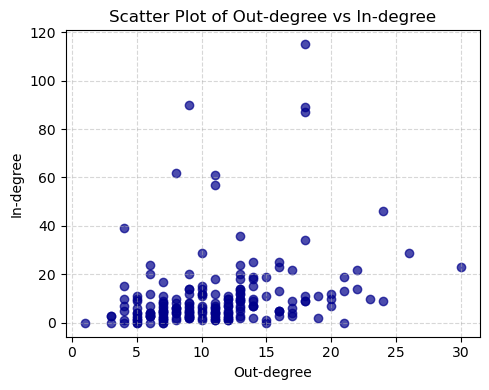

In [12]:
# in-degree and out-degree lists
in_d = [d for _, d in G.in_degree()]
out_d = [d for _, d in G.out_degree()]

plt.figure(figsize=(5, 4))
plt.scatter(out_d, in_d, marker='o', color='darkblue', alpha=0.7)
plt.title('Scatter Plot of Out-degree vs In-degree')
plt.xlabel('Out-degree')
plt.ylabel('In-degree')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 2. Degree distributions

### 2.1. In-degree and out-degree distributions

The histogram of the network’s in-degree distribution presents a heavy-tail, meaning most countries are mentioned on only a few other countries’ pages, while a small number of countries are referenced across many pages, consistent with the patterns observed in the previous scatter plot. On a log–log plot, the distribution declines almost linearly, indicating a possible power-law behavior.

The out-degree distribution is very narrow, with most nodes having between 5 and 20 out going links and almost none with higher degree. On the log–log plot, the pattern does not seem to follow a power law.

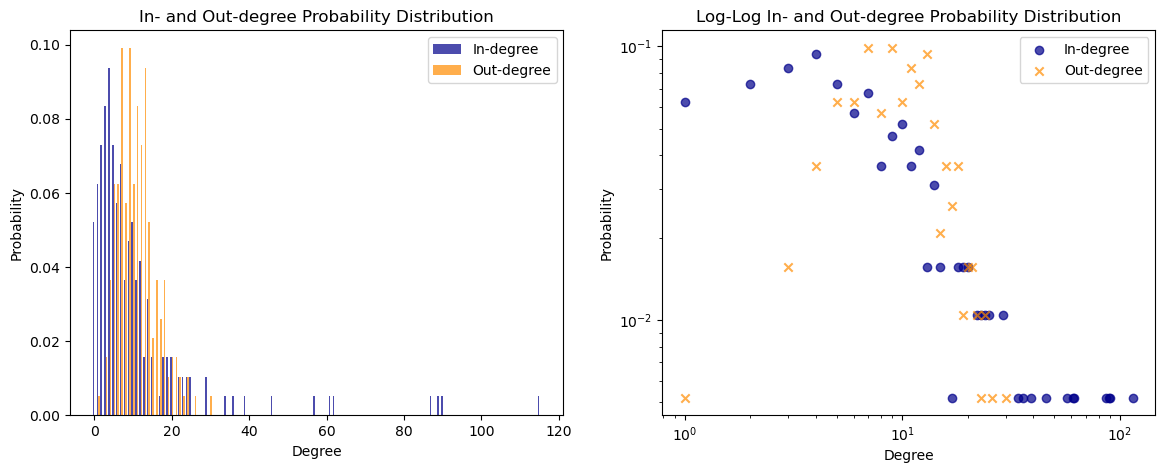

In [18]:
in_d_sort = sorted(in_d)
out_d_sort = sorted(out_d)

# bins
max_deg = max(max(in_d_sort), max(out_d_sort))
min_deg = min(min(in_d_sort), min(out_d_sort))
v = np.arange(min_deg, max_deg + 2)  

# in counts
in_counts, in_bins = np.histogram(in_d_sort, bins=v)
# in probabilities
in_probs = in_counts / in_counts.sum()

# out counts
out_counts, out_bins = np.histogram(out_d_sort, bins=v)
# out probabilities
out_probs = out_counts / out_counts.sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(v[:-1]-0.2, in_probs, width=0.4, color='darkblue', label='In-degree', alpha=0.7)
axes[0].bar(v[:-1]+0.2, out_probs, width=0.4, color='darkorange', label='Out-degree', alpha=0.7)
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Probability')
axes[0].set_title('In- and Out-degree Probability Distribution')
axes[0].legend()

axes[1].scatter(v[:-1], in_probs, marker='o', color='darkblue', label='In-degree', alpha=0.7)
axes[1].scatter(v[:-1], out_probs, marker='x', color='darkorange', label='Out-degree', alpha=0.7)
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Probability')
axes[1].set_title('Log-Log In- and Out-degree Probability Distribution')
axes[1].legend()

plt.show()

A power-law distribution is defined in Equation 4.1 of Barabási’s *Network Science*, Chapter 4 [1], by:

\begin{equation}
p_k \sim k^{-\gamma}
\tag{1}
\end{equation}

where $k$ is the variable and $\gamma$ is the **scaling exponent**, which determines how quickly probabilities decrease.

To investigate if the in-degree and out-degree distributions follow a power law, their exponents were estimated using the `powerlaw` package. 

For the in-degree distribution, the result was approximately $\gamma \approx 2.5$ for $x_{min} = 9$, meaning that the power-law fit applies to degrees higher than 9. This confirms, once again, that the in-degree distribution is heavy-tailed, with its tail following a power-law pattern. An exponent between 2 and 3 indicates scale-free characteristics, where a few highly connected nodes, called hubs, play an important role in the network’s structure. In this context, while most countries are mentioned few times, countries with very high in-degree correspond to influential countries. This observation aligns with the fact that the top 3 highest in-degree nodes are countries with an extensive and influential world history.

For the out-degree distribution the exponent was approximately $\gamma \approx 8.9$ for $x_{min} = 21$. The high value of 21 means the power-law model only applies to a very  small portion of the data, suggesting the network does not exhibit scale-free behavior, meaning hubs do not exist, unlike the in-degree distribution. 

In [19]:
fit_in = powerlaw.Fit(in_d,discrete=True,verbose=False)
alpha_in = fit_in.alpha
xmin_in=fit_in.xmin
print("In-degree exponent (alpha):", alpha_in)
print("xmin:", xmin_in)

fit_out = powerlaw.Fit(out_d,discrete=True,verbose=False)
alpha_out = fit_out.alpha
xmin_out=fit_out.xmin
print("Out-degree exponent (alpha):", alpha_out)
print("xmin:", xmin_out)

In-degree exponent (alpha): 2.460478818409286
xmin: 9.0
Out-degree exponent (alpha): 8.922052361640876
xmin: 21.0


In order to check if the distributions could follow a different model, we compared power-law, log-normal and exponential distribution models. 

For the in-degree distribution, the exponential distribution is clearly a worse fit than the power-law and lognormal, which was expected due to  heavy tail behaviour of the data. Between the power-law and the lognormal distribution, it is not clear which one is more likely. Overall, the heavy-tailed behaviour indicates that most nodes have low in-degrees, while a few hubs, the geopolitical central countries, present many connections.

Regarding the out-degree distribution, the data does not favor any model. In general, there is an homogeneous pattern of outgoing mentions, with all nodes have out-degree in the range 5 to 20, and no heavy-tail behaviour.

In [20]:
print("In-degree distribution model comparisons:")
R_ln_in, p_ln_in = fit_in.distribution_compare('power_law', 'lognormal')
print("Power-law vs lognormal: R =", R_ln_in, ", p =", p_ln_in)

R_exp_in, p_exp_in = fit_in.distribution_compare('power_law', 'exponential')
print("Power-law vs exponential: R =", R_exp_in, ", p =", p_exp_in)

R_expln_in, p_expln_in = fit_in.distribution_compare('lognormal', 'exponential')
print("Log-normal vs exponential: R =", R_expln_in, ", p =", p_expln_in)

print("\nOut-degree distribution model comparisons:")
R_ln_out, p_ln_out = fit_out.distribution_compare('power_law', 'lognormal')
print("Power-law vs lognormal: R =", R_ln_out, ", p =", p_ln_out)

R_exp_out, p_exp_out = fit_out.distribution_compare('power_law', 'exponential')
print("Power-law vs exponential: R =", R_exp_out, ", p =", p_exp_out)

R_expln_out, p_expln_out = fit_out.distribution_compare('lognormal', 'exponential')
print("Log-normal vs exponential: R =", R_expln_out, ", p =", p_expln_out)

In-degree distribution model comparisons:
Power-law vs lognormal: R = -0.31424322239286906 , p = 0.5551714729836246
Power-law vs exponential: R = 10.557681816492256 , p = 0.029199378221683767
Log-normal vs exponential: R = 10.871925038885147 , p = 0.012188251994433534

Out-degree distribution model comparisons:
Power-law vs lognormal: R = -0.1065296003825087 , p = 0.7271408933018562
Power-law vs exponential: R = -0.103208627962597 , p = 0.5941600128531492
Log-normal vs exponential: R = 0.003320972419911694 , p = 0.9764335107282895


### 2.2. Total-degree distribution

The total degree distribution is right-skewed and reflects the combination of the in-degree and out-degree distributions. Its long tail can be explained by the in-degree component, while its body comes from the moderate-in and moderate-out degrees in both distributions. It indicates that most countries have relatively few total connections, while a small number of countries have extremely high connectivity, suggesting the presence of hubs, as seen in the previous analysis. The log–log version of the plot also suggest the existence of those hubs but not a power-law behaviour.

Perguntar ao chat: como é pode parecer power law e ter hubs? No fundo os hubs sao os mm que in degree, ptt sendo uma mistura tem esses hubs?

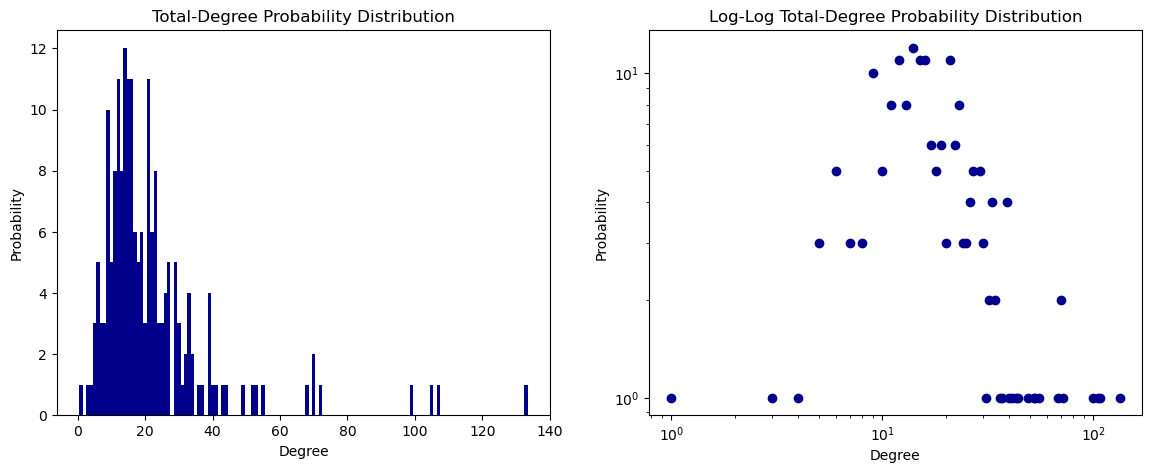

In [30]:
total_d = [d for _, d in G.degree()]
total_d_sort = sorted(total_d)

max_total=max(total_d_sort)
min_total=min(total_d_sort)
v_total=np.arange(min_total, max_total+2)

# counts
total_counts, total_bins = np.histogram(total_d_sort, bins=v_total)
# probabilities
total_probs = total_counts / total_counts.sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(total_bins[:-1], total_counts, width=np.diff(total_bins), color='darkblue')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Probability')
axes[0].set_title('Total-Degree Probability Distribution')
    
axes[1].scatter(total_bins[:-1], total_counts, marker='o', color = 'darkblue')
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Probability')
axes[1].set_title('Log-Log Total-Degree Probability Distribution')
plt.show()

From the exponent of the degree distribution and its $x_{min}$ we can conlude the distribution does not follow a power-law. Comparison between other models was also inconclusive. In the end, the heavy-tail of the total-degree distribution reflects the real geopolitical scene: some central countries dominate it, while most countries have smaller significance.

In [31]:
fit_total = powerlaw.Fit(total_d,discrete=True)
alpha_total = fit_total.alpha
xmin_total = fit_total.xmin
print("In-degree exponent (alpha):", alpha_total)
print("xmin:", xmin_total)

R_ln_out, p_ln_out = fit_total.distribution_compare('power_law', 'lognormal')
print("\nPower-law vs lognormal: R =", R_ln_out, ", p =", p_ln_out)

R_exp_out, p_exp_out = fit_total.distribution_compare('power_law', 'exponential')
print("Power-law vs exponential: R =", R_exp_out, ", p =", p_exp_out)

R_expln_out, p_expln_out = fit_total.distribution_compare('lognormal', 'exponential')
print("Log-normal vs exponential: R =", R_expln_out, ", p =", p_expln_out)

Calculating best minimal value for power law fit
In-degree exponent (alpha): 3.2242657700949136
xmin: 22.0

Power-law vs lognormal: R = -0.08512335032450125 , p = 0.7589328668041653
Power-law vs exponential: R = 4.476561699048047 , p = 0.12722236931743178
Log-normal vs exponential: R = 4.561685049372554 , p = 0.08732329684278976


## 3. *GDP per capita* attribute

In [34]:
gdp = np.array(list(nx.get_node_attributes(G, 'gdp').values()))
out_degree = np.array(list(dict(G.out_degree()).values()))
in_degree = np.array(list(dict(G.in_degree()).values()))

pearson_out = pearsonr(gdp, out_degree)
pearson_in = pearsonr(gdp, in_degree)
print("Pearson correlation (Out-Degree):", pearson_out[0])
print("Pearson correlation (In-Degree):", pearson_in[0])

Pearson correlation (Out-Degree): -0.04029142495381917
Pearson correlation (In-Degree): 0.17992796127086905


## 4. Centrality

Centrality measures the relative importance of nodes within a network, with different metrics capturing different aspects of that importance. We focus on three types: degree centrality, betweenness centrality and eigenvector centrality.

**In-degree** [3] **and out-degree centrality** [4] are calculated by normalizing the number of incoming or outgoing links for each node so nodes with more links are considered more central.

In [39]:
indegree_c = nx.in_degree_centrality(G)
sorted_in = sorted(indegree_c.items(), key=lambda x: x[1], reverse=True)
top5_in = [sorted_in[i][0] for i in range(5)]
print("Top 5 nodes by in-degree centrality:", top5_in)

outdegree_c = nx.out_degree_centrality(G)
sorted_out = sorted(outdegree_c.items(), key=lambda x: x[1], reverse=True)
top5_out = [sorted_out[i][0] for i in range(5)]
print("Top 5 nodes by out-degree centrality:", top5_out)

Top 5 nodes by in-degree centrality: ['United_States', 'France', 'United_Kingdom', 'Germany', 'China']
Top 5 nodes by out-degree centrality: ['Cuba', 'Iran', 'Russia', 'Nicaragua', 'Argentina']


**Betweenness centrality** [5] measures how often a node lies on the shortest paths between other nodes, identifying the ones that act as bridges in the network. In a countries' history network, these nodes act as historical connectors and can bridge different historical narratives or regions. These countries can be involved in widely cited historical events that link otherwise disconnected countries. Interestingly, the top five countries with the highest betweenness centrality also rank highly in either in-degree or out-degree centrality, suggesting a relationship between the number of connections and a node’s role as a bridge. This also indicates that France is not as prominent in connecting different parts of the network as it is influential, for example.

In [40]:
bet_c=nx.betweenness_centrality(G) 
sorted_bet_c = sorted(bet_c.items(), key=lambda x: x[1], reverse=True) 
print("Top 5 nodes by betweenness centrality:")
for node, value in sorted_bet_c[:5]:
    print(f"{node}: {value:.4f}")

Top 5 nodes by betweenness centrality:
Cuba: 0.1046
United_States: 0.0888
Russia: 0.0797
United_Kingdom: 0.0778
Germany: 0.0763


**Eigenvector centrality** [6] assigns higher scores to nodes that are connected to other highly scored nodes. In-eigenvector centrality measures importance of a node based on the importance of nodes pointing to it. Nodes with high in-eigenvector centrality are referenced by other highly influential nodes. Out-eigenvector centrality measures a node’s importance based on the importance of nodes it points to. With this centrality measure, some different countries come up as Iran and Israel, that might mention very influential countries in their history, although they are not mentioned in many countries histories.

In [42]:
ineig_c = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06) 
top5_in = sorted(ineig_c.items(), key=lambda x: x[1], reverse=True)
print("Top 5 nodes by in-eigenvector centrality:")
for node, value in top5_in[:5]:
    print(f"{node}: {value:.4f}")

outeig_c = nx.eigenvector_centrality(G.reverse(), max_iter=1000, tol=1e-06) 
top5_out = sorted(outeig_c.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 nodes by out-eigenvector centrality:")
for node, value in top5_out[:5]:
    print(f"{node}: {value:.4f}")

Top 5 nodes by in-eigenvector centrality:
Germany: 0.3508
United_States: 0.3491
France: 0.3422
United_Kingdom: 0.2930
Russia: 0.2632

Top 5 nodes by out-eigenvector centrality:
Cuba: 0.1878
Iran: 0.1563
Israel: 0.1499
Nicaragua: 0.1491
Russia: 0.1485


### 4.1. Betweenness centrality vs degree centrality

Plotting betweenness centrality against in-degree centrality shows how a node’s role as a bridge relates to its influence in the network. The strong positive correlation of 0.787 indicates that nodes with higher betweenness centrality generally also have higher in-degree centrality. In this network, this suggests that countries who connect different parts of the network are often influential countries with many references.

On the other hand, the correlation value between betweenness centrality and out-degree centrality is 0.57, indicating that artists who act as bridges often have high out-degree as well, although the relationship is less strong than with in-degree.

Pearson correlation (In-Degree): 0.7866808435410306
Pearson correlation (Out-Degree): 0.5725470746839684


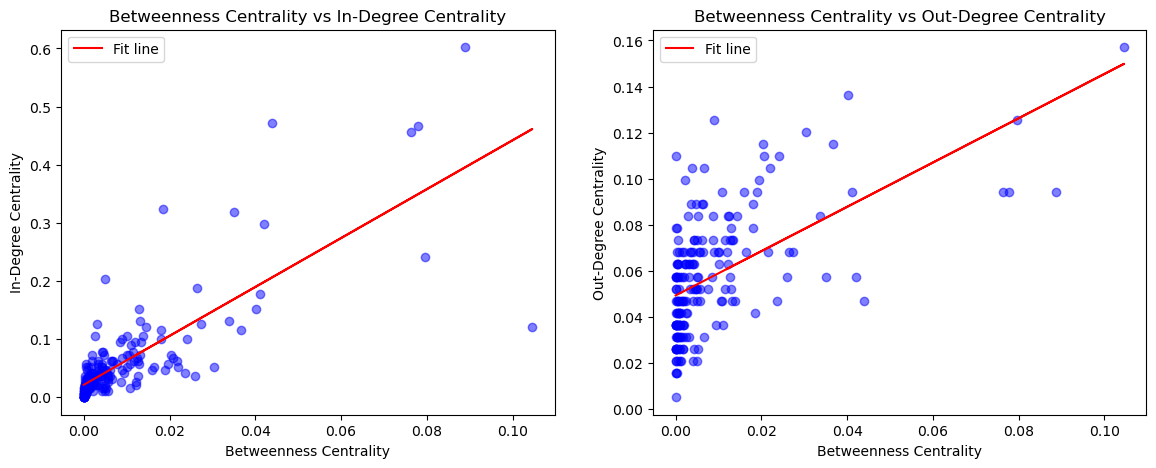

In [43]:
bet_c_list = list(bet_c.values())
indegree_c_list = list(indegree_c.values())
outdegree_c_list = list(outdegree_c.values())

pearson_corr_in = pearsonr(bet_c_list, indegree_c_list)
pearson_corr_out = pearsonr(bet_c_list, outdegree_c_list)
print("Pearson correlation (In-Degree):", pearson_corr_in[0])
print("Pearson correlation (Out-Degree):", pearson_corr_out[0])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(bet_c_list, indegree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(bet_c_list, indegree_c_list, 1)
axes[0].plot(bet_c_list, slope * np.array(bet_c_list) + intercept, color='red', label='Fit line')
axes[0].set_title(f"Betweenness Centrality vs In-Degree Centrality")
axes[0].set_xlabel("Betweenness Centrality")
axes[0].set_ylabel("In-Degree Centrality")
axes[0].legend()

axes[1].scatter(bet_c_list, outdegree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(bet_c_list, outdegree_c_list, 1)
axes[1].plot(bet_c_list, slope * np.array(bet_c_list) + intercept, color='red', label='Fit line')
axes[1].set_title(f"Betweenness Centrality vs Out-Degree Centrality")
axes[1].set_xlabel("Betweenness Centrality")
axes[1].set_ylabel("Out-Degree Centrality")
axes[1].legend()
plt.show()

### 4.2. Eigenvector centrality vs degree centrality

The correlation between in-degree centrality and in-eigenvector centrality is 0.926, indicating a very strong positive relationship, as can be seen in the first plot. In-degree centrality counts how many nodes point to a node, while in-eigenvector centrality also considers the importance of those linking nodes. This means that nodes with many incoming links are generally referenced by influential nodes as well, showing that in-degree is a good measure of overall influence in the network. 

The correlation between out-degree centrality and out-eigenvector centrality is 0.947, indicating a stronger positive relationship. This shows that countries that mention many other countries tend to mention important ones.

Pearson correlation (In-Degree vs In-Eigenvector): 0.9262261683026625
Pearson correlation (Out-Degree vs Out-Eigenvector): 0.9467217905565464


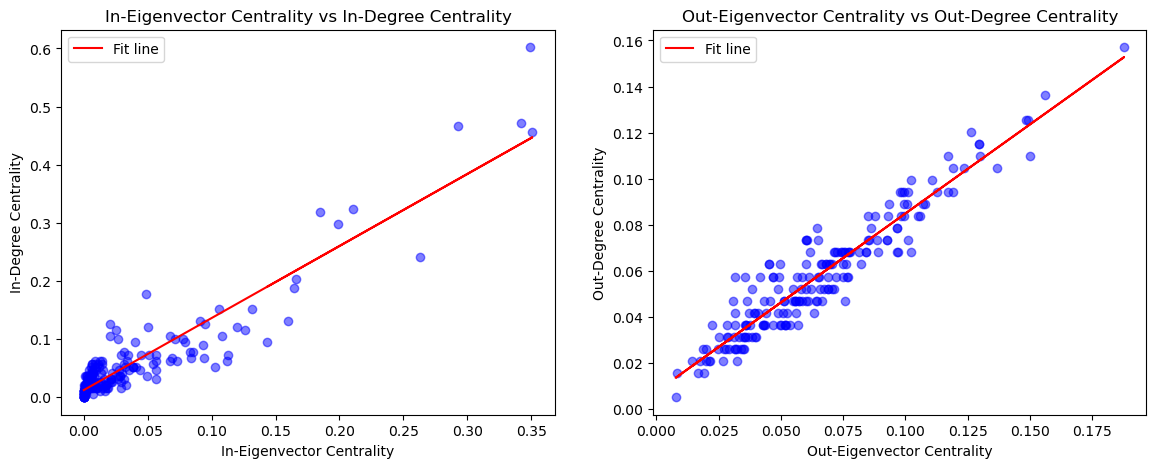

In [44]:
ineig_c_list = list(ineig_c.values())
outeig_c_list = list(outeig_c.values())

pearson_corr_in = pearsonr(ineig_c_list, indegree_c_list)
pearson_corr_out = pearsonr(outeig_c_list, outdegree_c_list)
print("Pearson correlation (In-Degree vs In-Eigenvector):", pearson_corr_in[0])
print("Pearson correlation (Out-Degree vs Out-Eigenvector):", pearson_corr_out[0])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(ineig_c_list, indegree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(ineig_c_list, indegree_c_list, 1)
axes[0].plot(ineig_c_list, slope * np.array(ineig_c_list) + intercept, color='red', label='Fit line')
axes[0].set_title(f"In-Eigenvector Centrality vs In-Degree Centrality")
axes[0].set_xlabel("In-Eigenvector Centrality")
axes[0].set_ylabel("In-Degree Centrality")
axes[0].legend()

axes[1].scatter(outeig_c_list, outdegree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(outeig_c_list, outdegree_c_list, 1)
axes[1].plot(outeig_c_list, slope * np.array(outeig_c_list) + intercept, color='red', label='Fit line')
axes[1].set_title(f"Out-Eigenvector Centrality vs Out-Degree Centrality")
axes[1].set_xlabel("Out-Eigenvector Centrality")
axes[1].set_ylabel("Out-Degree Centrality")
axes[1].legend()
plt.show()

## 5. Assortativity

Assortativity measures the tendency of nodes in a network to connect to other nodes that are similar, such as by degree [7] or attribute [8].

In the case of **assortativity relative to degree**, it indicates whether high-degree nodes tend to connect with other high-degree nodes, being assortative, or with low-degree nodes, being disassortative. For this network, the assortativity value is very close to zero, meaning that connections are random with respect to degree, occurring without a preference for nodes with similar or dissimilar degree. This is not surprising given the context of the network, where both high-degree countries and low-degree countries most likely reference high-degree countries, breaking any type of assortativity pattern.

In [5]:
G_und=G.to_undirected(reciprocal=False, as_view=False)
degree_assort=nx.degree_assortativity_coefficient(G_und)
print("Degree assortativity coefficient:", degree_assort)

Degree assortativity coefficient: -0.17715975837934467


In [6]:
G_und.number_of_edges()

1748

**Assortativity relative to gdp** is also very close to zero, indicating that connections are essentially random regarding a country's gdp.

**Assortativity relative to language** is higher but still close to zero, meaning connections might follow some pattern but it is not obvious.

**Assortativity relative to continent** is higher and shows that countries tend to connect to countries in the same continent.

In [46]:
degree_assort_length=nx.attribute_assortativity_coefficient(G_und,"gdp")
degree_assort_length
print("Length of content assortativity coefficient:", degree_assort_length)

Length of content assortativity coefficient: -0.009018909957192293


In [49]:
degree_assort_length=nx.attribute_assortativity_coefficient(G_und,"official_language")
degree_assort_length
print("Length of content assortativity coefficient:", degree_assort_length)

Length of content assortativity coefficient: 0.11952801260930632


In [50]:
degree_assort_length=nx.attribute_assortativity_coefficient(G_und,"continent")
degree_assort_length
print("Length of content assortativity coefficient:", degree_assort_length)

Length of content assortativity coefficient: 0.38825608263098754


## 6. Backbone structure

The backbone structure of the original network was extracted using the backbone extraction package by Michele Coscia [9]. Edge betweenness centrality [10], which measures the number of shortest paths passing through each edge, was used to assign weights to the network edges, while the disparity filter from the backbone extraction package provided a significance score for each edge, allowing us to retain only the most important connections. The threshold was chosen to preserve the core structure and connectivity without excessive fragmentation, ensuring the analysis remains meaningful.

The resulting backbone network has 167 nodes connected by 360 edges and highlights the most important connections of the original network. It consists of 1 connected component. Comparing the original network structure with the backbone, we conclude that hubs dominate both structures since a small number of artists have very high degrees.

In [94]:


G_copy = G_und.copy()
edge_bet = nx.edge_betweenness_centrality(G_copy)

# normalize to [0, 100]
values = np.array(list(edge_bet.values()))
v_min, v_max = values.min(), values.max()
edge_bet_norm = 1 + 99 * (values - v_min) / (v_max - v_min)

# assign normalized weights to edges
for (edge, norm_val) in zip(edge_bet.keys(), edge_bet_norm):
    u, v = edge
    G_copy[u][v]['weight'] = norm_val

# table with src, trg and nij
edges = nx.to_pandas_edgelist(G_copy)
edges.rename(columns={'source':'src', 'target':'trg', 'weight':'nij'}, inplace=True)

# method to add score, use disparity filter
disparity_filter = backboning.disparity_filter(edges, undirected=True)
# threshold the scores and get the backbone structure
backbone_edges = backboning.thresholding(disparity_filter, threshold=0.7)

# convert table into network x
G_backbone = nx.from_pandas_edgelist(backbone_edges, source='src', target='trg', edge_attr='score')

print(f"Original Undirected Network: {len(G_copy.nodes())} nodes, {len(G_und.edges())} edges")
print(f"Backbone Network: {len(G_backbone.nodes())} nodes, {len(G_backbone.edges())} edges")

components = list(nx.connected_components(G_backbone))
print(f"\nBackbone network has {len(components)} components")
print("Sizes of components:", [len(c) for c in components])

largest_component = max(components, key=len)
G_largest = G_backbone.subgraph(largest_component).copy()

Original Undirected Network: 192 nodes, 1748 edges
Backbone Network: 167 nodes, 360 edges

Backbone network has 1 components
Sizes of components: [167]


Calculating DF score...


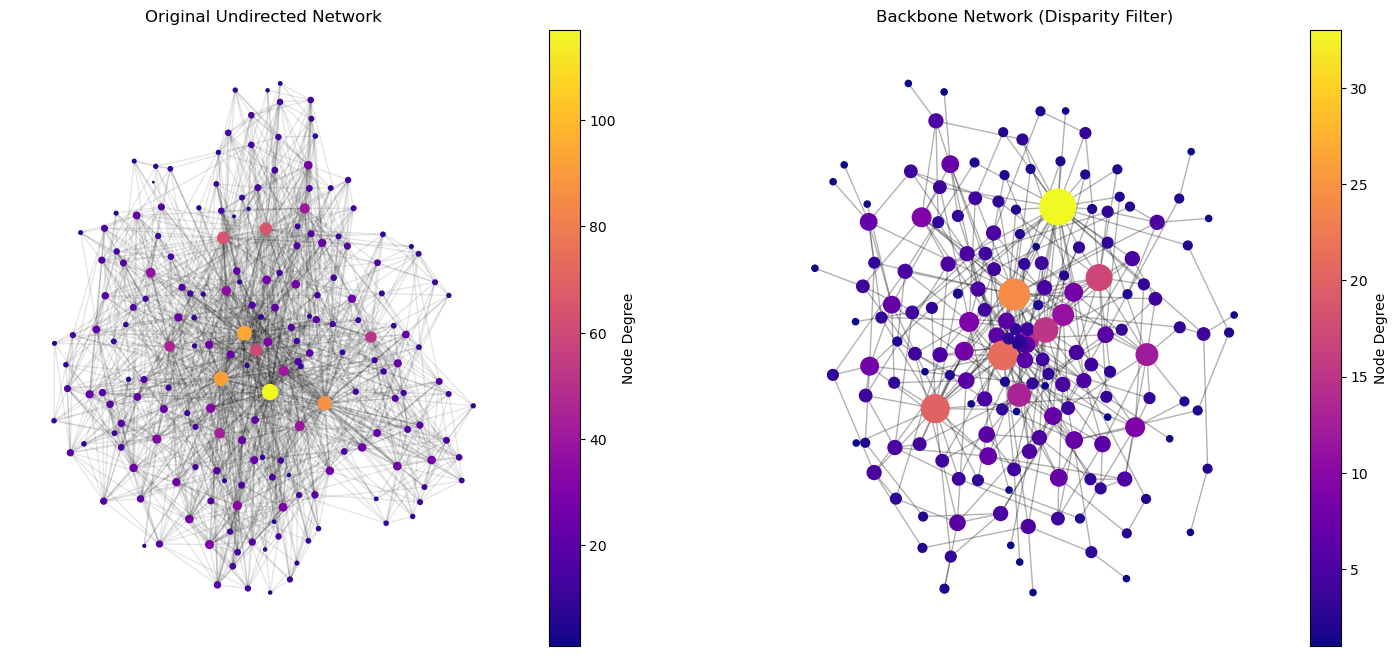

In [95]:
degrees_orig = dict(G_copy.degree())
degrees_back = dict(G_backbone.degree())

# node size
node_size_orig = [degrees_orig[n] for n in G_copy.nodes()]
node_size_back = [degrees_back[n]*20 for n in G_backbone.nodes()]

# node color
node_color_orig = [degrees_orig[n] for n in G_copy.nodes()]
node_color_back = [degrees_back[n] for n in G_backbone.nodes()]

pos_springf_orig = nx.forceatlas2_layout(G_copy, max_iter=100, gravity=25)
pos_springf_back = nx.forceatlas2_layout(G_backbone, max_iter=100, gravity=25)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
nodes_orig=nx.draw_networkx_nodes(G_copy, pos=pos_springf_orig, node_size=node_size_orig, node_color=node_color_orig, cmap=plt.cm.plasma, ax=axes[0])
nx.draw_networkx_edges(G_copy, pos=pos_springf_orig, alpha=0.1, ax=axes[0])
axes[0].set_title("Original Undirected Network")
axes[0].axis("off")
cbar_orig = plt.colorbar(nodes_orig, ax=axes[0])
cbar_orig.set_label("Node Degree")

nodes_back=nx.draw_networkx_nodes(G_backbone, pos=pos_springf_back, node_size=node_size_back, node_color=node_color_back, cmap=plt.cm.plasma, ax=axes[1])
nx.draw_networkx_edges(G_backbone, pos=pos_springf_back, alpha=0.3, ax=axes[1])
axes[1].set_title("Backbone Network (Disparity Filter)")
axes[1].axis("off")
cbar_back = plt.colorbar(nodes_back, ax=axes[1])
cbar_back.set_label("Node Degree")
plt.show()

By comparing the highest-degree nodes in the original and backbone networks, we conclude that nodes appearing in both lists are highly influential countries that also have a structural importance, as they retain key connections in the backbone.

In [96]:
# Highest degree nodes in original network
deg_orig = dict(G_copy.degree())
top_orig = sorted(deg_orig.items(), key=lambda x: x[1], reverse=True)[:10]

# Highest degree nodes in backbone network
deg_back = dict(G_largest.degree())
top_back = sorted(deg_back.items(), key=lambda x: x[1], reverse=True)[:10]

df_top = pd.DataFrame({
    "Original Network": [node for node, _ in top_orig],
    "Backbone Network": [node for node, _ in top_back],
})

print("Top 10 Highest Degree Nodes in Original and Backbone Networks:")
display(df_top)

common_nodes = set([node for node, _ in top_orig]) & set([node for node, _ in top_back])
print("\nNodes appearing in both top 10 lists:", common_nodes)

Top 10 Highest Degree Nodes in Original and Backbone Networks:


,Original Network,Backbone Network
0,United_States,United_States
1,United_Kingdom,United_Kingdom
2,France,Germany
3,Germany,France
4,China,Spain
5,India,Russia
6,Spain,China
7,Russia,India
8,Portugal,Portugal
9,Cuba,Nicaragua



Nodes appearing in both top 10 lists: {'Russia', 'India', 'Portugal', 'Spain', 'Germany', 'France', 'China', 'United_States', 'United_Kingdom'}


Comparing the plot of betweenness vs degree centrality of the backbone to the ones in section 4.1., **betweenness centrality** values are higher in the backbone network than in the original one, which makes sense since only the most significant edges are retained. 

Nodes with the highest betweenness centrality in the backbone, such as United_States', 'United_Kingdom', 'Germany', 'France', 'Russia, act as key bridges connecting different parts of the network. The correlation between **degree centrality** and **betweenness centrality** in the backbone is 0.961, indicating that these bridging nodes are likely influential countries.

The relationship between **eigenvector centrality** and **degree centrality** is also strong in the backcone, with a correlation of 0.837. This means that nodes that have a high degree tend to connect to important nodes.

In [97]:
degree_c = nx.degree_centrality(G_largest)
bet_c = nx.betweenness_centrality(G_largest)
eigen_c = nx.eigenvector_centrality(G_largest, max_iter=1000)

sorted_degree = sorted(degree_c.items(), key=lambda x: x[1], reverse=True)
top5_deg = [sorted_degree[i][0] for i in range(5)]
print("Top 5 nodes by degree centrality:", top5_deg)

sorted_bet= sorted(bet_c.items(), key=lambda x: x[1], reverse=True)
top5_bet = [sorted_bet[i][0] for i in range(5)]
print("Top 5 nodes by betweenness centrality:", top5_bet)

sorted_eigen = sorted(eigen_c.items(), key=lambda x: x[1], reverse=True)
top5_eigen = [sorted_eigen[i][0] for i in range(5)]
print("Top 5 nodes by eigenvector centrality:", top5_eigen)

Top 5 nodes by degree centrality: ['United_States', 'United_Kingdom', 'Germany', 'France', 'Spain']
Top 5 nodes by betweenness centrality: ['United_States', 'United_Kingdom', 'Germany', 'France', 'Russia']
Top 5 nodes by eigenvector centrality: ['United_States', 'United_Kingdom', 'Russia', 'Germany', 'China']


Pearson correlation (Betweenness vs Degree Centrality): 0.960706688087999
Pearson correlation (Eigenvector vs Degree Centrality): 0.8367400662132344


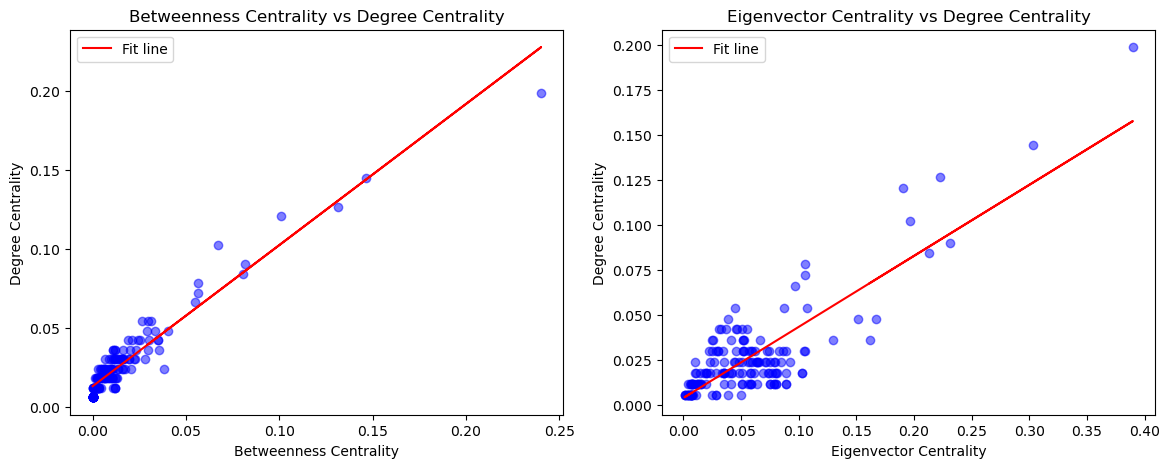

In [98]:
from scipy.stats import pearsonr

degree_c_list = list(degree_c.values())
bet_c_list = list(bet_c.values())
eigen_c_list = list(eigen_c.values())

pearson_corr_bet = pearsonr(bet_c_list, degree_c_list)
print("Pearson correlation (Betweenness vs Degree Centrality):", pearson_corr_bet[0])

pearson_corr_eig = pearsonr(eigen_c_list, degree_c_list)
print("Pearson correlation (Eigenvector vs Degree Centrality):", pearson_corr_eig[0])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(bet_c_list, degree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(bet_c_list, degree_c_list, 1)
axes[0].plot(bet_c_list, slope * np.array(bet_c_list) + intercept, color='red', label='Fit line')
axes[0].set_title(f"Betweenness Centrality vs Degree Centrality")
axes[0].set_xlabel("Betweenness Centrality")
axes[0].set_ylabel("Degree Centrality")
axes[0].legend()

axes[1].scatter(eigen_c_list, degree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(eigen_c_list, degree_c_list, 1)
axes[1].plot(eigen_c_list, slope * np.array(eigen_c_list) + intercept, color='red', label='Fit line')
axes[1].set_title(f"Eigenvector Centrality vs Degree Centrality")
axes[1].set_xlabel("Eigenvector Centrality")
axes[1].set_ylabel("Degree Centrality")
axes[1].legend()
plt.show()